## Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression


#Q5 - (b) - Evaluate the model on Speed limit 100km/h vs 120km/h using the unaligned dataset

In [2]:
#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
X,Y = traffic_sign(False) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y

load_data_binary = select_binarydata(load_data,7,8)
#data splits 80/10/10
train_data, train_label, valid_data, valid_label, test_data, test_label = generate_no_fold_set(load_data_binary,10)


(34799, 1024) (34799,)
FOLDWIDTH: 255


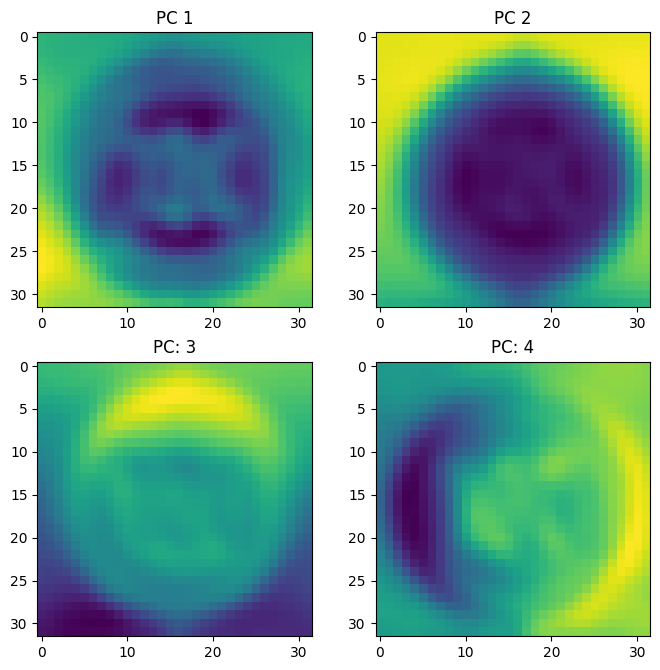

 best test accuracy : 0.8941176470588236


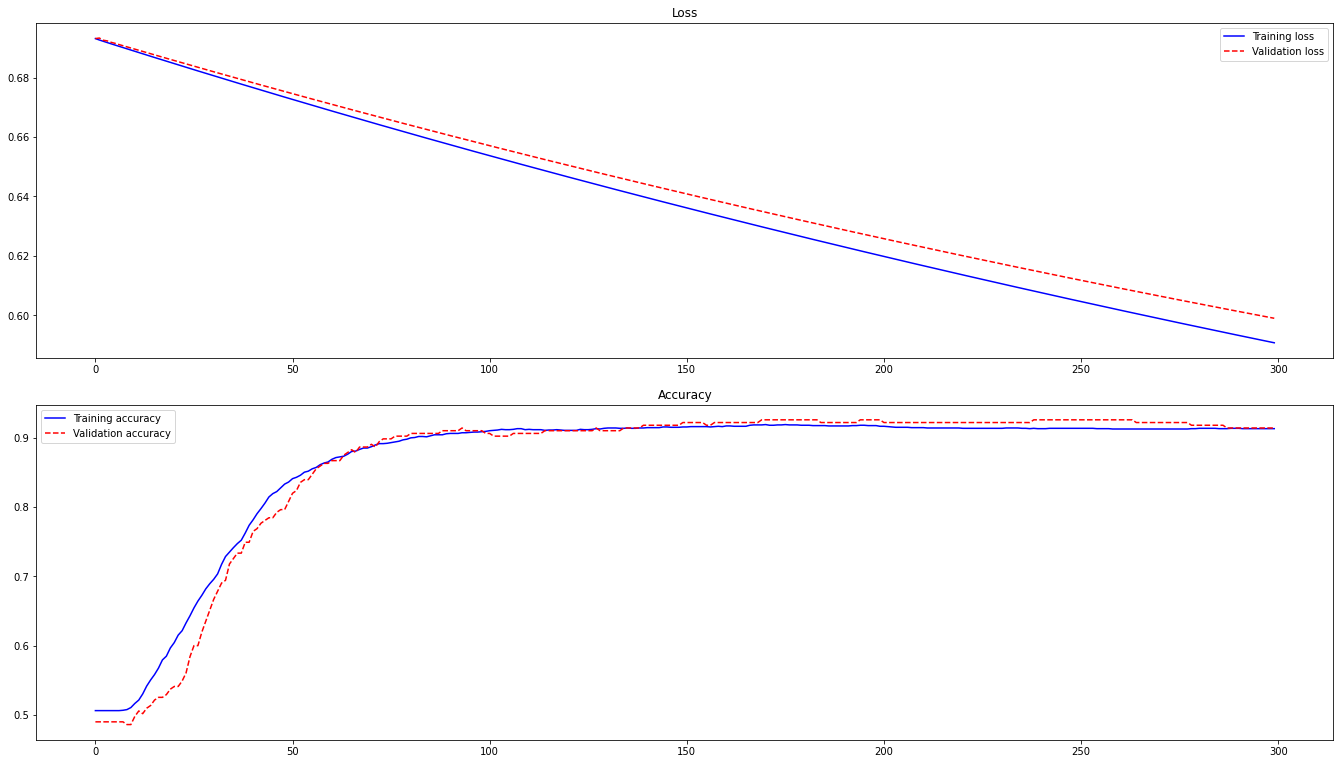

In [3]:
#train 50 epochs as opposed to 300
#learning rate
n_components = 200


pca = PCA(n_components)
projected = pca.fit_transform(train_data)
pca.plot_PC()

train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []

train_l = np.copy(train_label)//8 # 7 or 8
valid_l = np.copy(valid_label)//8 # 7 or 8
test_l = np.copy(test_label)//8 # 7 or 8

Alpha = 0.003
w = np.zeros((n_components+1))
b = 0

logistic = LogisticRegression(Alpha,n_components)
#weight
train_d = projected 
valid_d = pca.transform(valid_data)
test_d = pca.transform(test_data)
epochs = 300
for epoch in range(epochs):
    #logistic model 
    train_y = logistic.logistic_model(w, train_d,b)
    #loss check and normalize
    train_loss = logistic.loss_binary(train_y, train_l)
    train_loss_norm = train_loss / len(train_y)
    #gradient check
    train_loss_record.append(train_loss_norm)
    train_accuracy = logistic.check_accuracy(train_y, train_l)
    train_accuracy_record.append(train_accuracy)
    #process for validation sets only checking the accuray, not updating the weight
    holdout_y = logistic.logistic_model(w,valid_d,b)
    holdout_loss = logistic.loss_binary(holdout_y, valid_l)
    holdout_loss_norm = holdout_loss/ len(holdout_y)
    holdout_accuracy = logistic.check_accuracy(holdout_y, valid_l)
    holdout_loss_record.append(holdout_loss_norm)
    holdout_accuracy_record.append(holdout_accuracy)
    #evaluate best option for test sets
    
    if holdout_accuracy >= max(holdout_accuracy_record):
        best_w = w
        best_b = b
    #update the weight
    w,b = logistic.update_weight(w,b, train_d, train_y, train_l)
    
test_y = logistic.logistic_model(best_w, test_d, best_b)
test_accuracy = logistic.check_accuracy(test_y, test_l)    
        
print(f' best test accuracy : {test_accuracy }')
#plot result

fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

axs[0].plot(train_loss_record, '-b', label='Training loss')
axs[0].plot(holdout_loss_record, '--r', label='Validation loss')
axs[0].legend();
axs[0].set_title('Loss')

axs[1].plot(train_accuracy_record, '-b', label='Training accuracy')
axs[1].plot(holdout_accuracy_record, '--r', label='Validation accuracy')
axs[1].legend();
axs[1].set_title('Accuracy')

plt.show()
   

#Q5 - (c) - Evaluate the model on Speed limit 100km/h vs 120km/h using the aligned dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y

load_data_binary = select_binarydata(load_data,7,8)
#data normalize


(34799, 1024) (34799,)


**********
Current Fold: 0


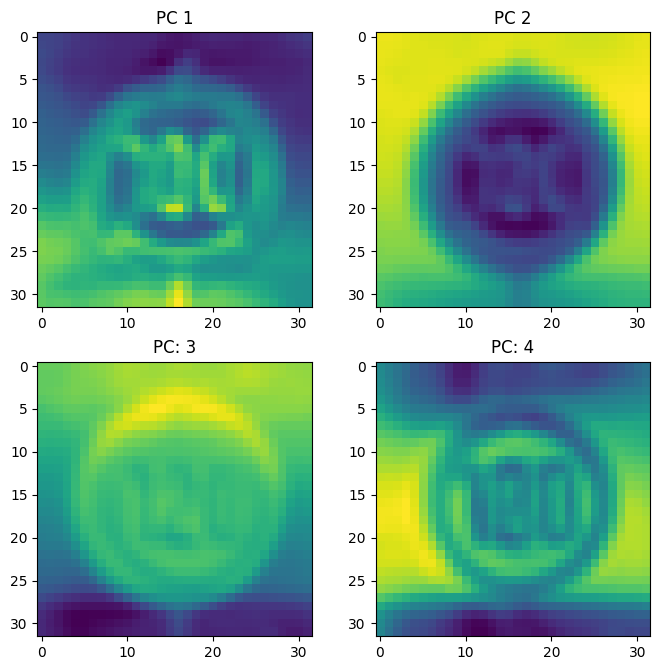

Test accuracy: 0.9451
Test loss norm: 0.5611
**********
Current Fold: 1
Test accuracy: 0.9804
Test loss norm: 0.5635
**********
Current Fold: 2
Test accuracy: 0.9804
Test loss norm: 0.5681
**********
Current Fold: 3
Test accuracy: 0.9686
Test loss norm: 0.5611
**********
Current Fold: 4
Test accuracy: 0.9843
Test loss norm: 0.5583
**********
Current Fold: 5
Test accuracy: 0.9804
Test loss norm: 0.5553
**********
Current Fold: 6
Test accuracy: 0.9647
Test loss norm: 0.5684
**********
Current Fold: 7
Test accuracy: 0.9725
Test loss norm: 0.5644
1
**********
Current Fold: 8
Test accuracy: 0.9608
Test loss norm: 0.5617
2
**********
Current Fold: 9
Test accuracy: 0.9686
Test loss norm: 0.5649
Average test accuracy over 10 folds: 0.9705882352941175
std of test accuracy over 10 folds: 0.01126384832654514
Average test loss per example and class over 10 folds: 0.5626782078461223


In [5]:
Debug = False
#recording data for plot
train_loss_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

train_accuracy_record = []

Alpha  = 0.003
n_components = 200
epochs_print = [50, 100, 150, 200, 250, 300]
epochs = 300
cur_fold = 0
k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

#fold sets add
first_plot = True
for train, valid, test in generate_k_fold_set((load_data_binary),k=10):
    print("**********")
    print(f"Current Fold: {cur_fold}")
    test_accuracy = []
    holdout_accuracy = []

    #w = np.random.rand(n_components)
    w = np.zeros((n_components+1))
    b = 0
    #first_plot = True
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    

    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    #plot first principle component
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.transform(valid_data)
    test_d = pca.transform(test_data)
    train_l = np.copy(train_label)//8
    valid_l = np.copy(valid_label)//8
    test_l = np.copy(test_label)//8
    
    logistic = LogisticRegression(Alpha,n_components)
  
    for epoch in range(epochs):
        #logistic model 
        train_y = logistic.logistic_model(w, train_d,b)
        #loss check
        train_loss = logistic.loss_binary(train_y, train_l)
        train_loss_norm = train_loss/len(train_y)
        #gradient check
        train_loss_record.append(train_loss_norm)
        train_accuracy = logistic.check_accuracy(train_y, train_l)
        train_accuracy_record.append(train_accuracy)
        #process for validation sets only checking the accuray, not updating the weight
        holdout_y = logistic.logistic_model(w,valid_d,b)
        holdout_loss = logistic.loss_binary(holdout_y, valid_l)
        holdout_loss_norm = holdout_loss/len(holdout_y)
        holdout_accuracy = logistic.check_accuracy(holdout_y, valid_l)
        holdout_loss_record.append(holdout_loss_norm)
        holdout_accuracy_record.append(holdout_accuracy)
        #evaluate best option for test sets
        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * epochs:]):
            best_w = w
            best_b = b
            
        #update the weight
        w,b = logistic.update_weight(w,b,train_d, train_y, train_l)
    
        if Debug : 
            if (epoch + 1) in epochs_print:
                print(f' epoch: {epoch + 1}, train accuracy and loss: {train_accuracy, train_loss_norm}')

    test_y = logistic.logistic_model(best_w, test_d, best_b)
    test_accuracy = logistic.check_accuracy(test_y, test_l)            
    test_accuracy_record.append(test_accuracy)
    
    print(f'Test accuracy: {test_accuracy:.4f}')
    total_test_accuracy += test_accuracy
    test_loss = logistic.loss_binary(test_y, test_l)
    test_loss_norm = test_loss / len(test_y)
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")    


    #update fold
    cur_fold += 1


print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
print(f'std of test accuracy over {k} folds: {np.std(test_accuracy_record)}')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')

    

In [6]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] = new_data[j] + data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

def get_data_at_epoch_fold(data, epoch, total_num_folds=10):
    # Returns a new list of data points at a specified epoch from all folds
    # data = [fold1....fold10]
    # epoch is 0-indexed
    epoch_per_fold = len(data) // total_num_folds
    new_data = [data[f * (epoch_per_fold) + epoch] for f in range(total_num_folds)]
    return new_data # [epoch n from fold1, epoch n from fold2, ..., epoch n from fold10]


Text(0.5, 1.0, 'Accuracy vs. Epochs')

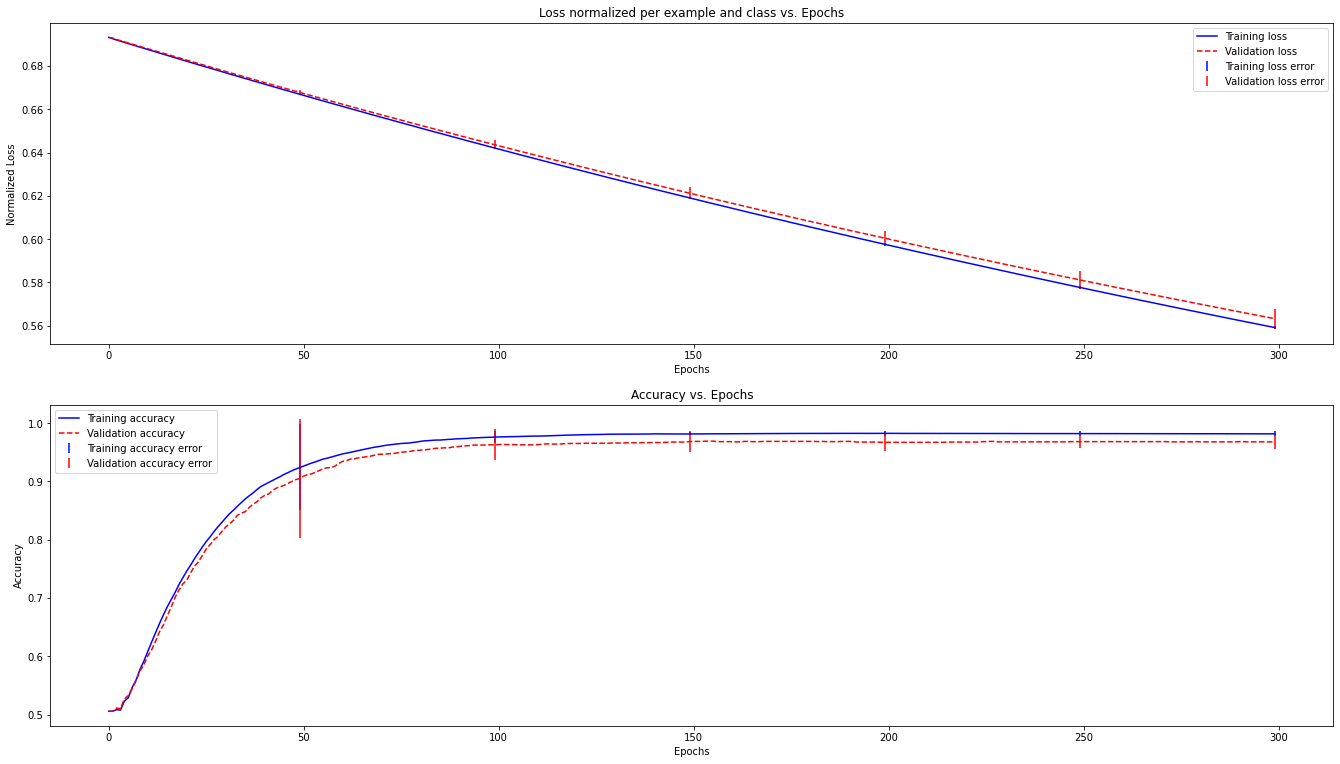

In [7]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)

train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]


axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b',linestyle='')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r',linestyle='')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b',linestyle='')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r',linestyle='')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')


# standard deviation error bars.


In [8]:
#-(c) 3times simulation with different learning rate

(34799, 1024) (34799,)
**********
Current Fold: 0


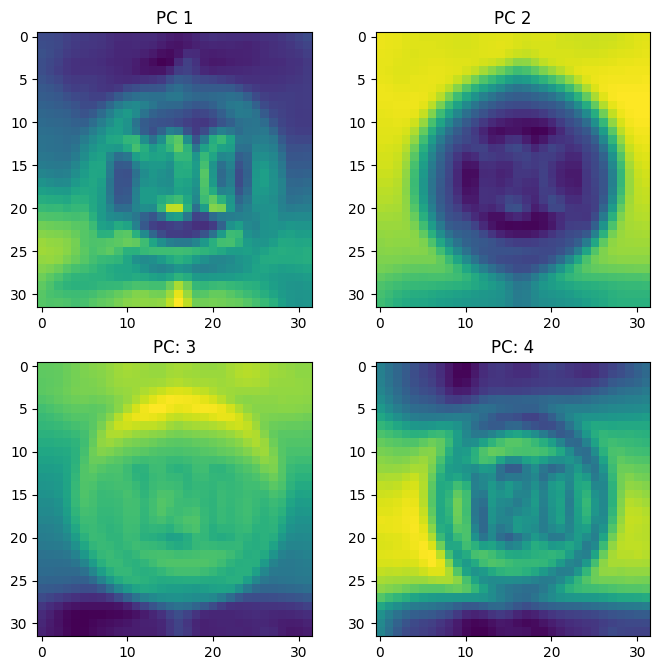

Test accuracy: 0.9686
Test loss norm: 0.1950
**********
Current Fold: 1
Test accuracy: 0.9686
Test loss norm: 0.1778
**********
Current Fold: 2
Test accuracy: 0.9804
Test loss norm: 0.1865
**********
Current Fold: 3
Test accuracy: 0.9451
Test loss norm: 0.1871
**********
Current Fold: 4
Test accuracy: 0.9765
Test loss norm: 0.1664
**********
Current Fold: 5
Test accuracy: 0.9882
Test loss norm: 0.1701
**********
Current Fold: 6
Test accuracy: 0.9569
Test loss norm: 0.1495
**********
Current Fold: 7
Test accuracy: 0.9569
Test loss norm: 0.1683
1
**********
Current Fold: 8
Test accuracy: 0.9765
Test loss norm: 0.1503
2
**********
Current Fold: 9
Test accuracy: 0.9451
Test loss norm: 0.1875
Average test accuracy over 10 folds: 0.9662745098039215
std of test accuracy over 10 folds: 0.01405213558209327
Average test loss per example and class over 10 folds: 0.17384800721900193
**********
Current Fold: 0


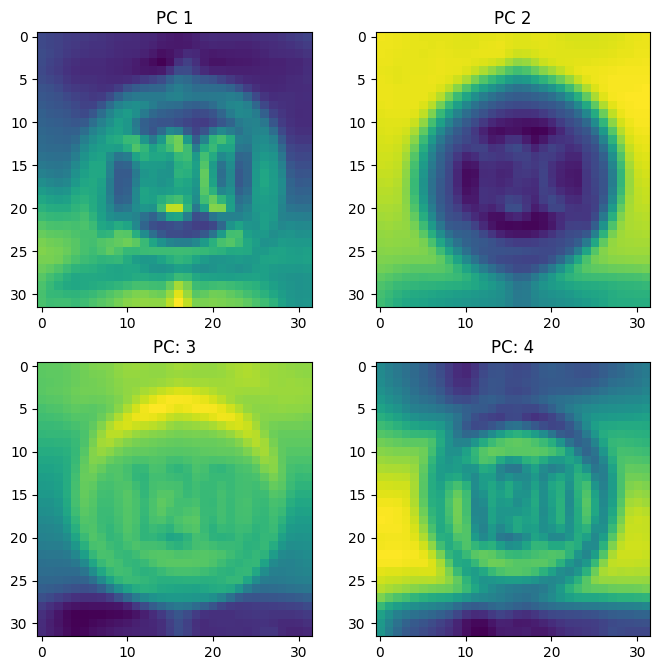

Test accuracy: 0.7137
Test loss norm: 0.6768
**********
Current Fold: 1
Test accuracy: 0.5451
Test loss norm: 0.6774
**********
Current Fold: 2
Test accuracy: 0.9647
Test loss norm: 0.6746
**********
Current Fold: 3
Test accuracy: 0.9765
Test loss norm: 0.6751
**********
Current Fold: 4
Test accuracy: 0.8706
Test loss norm: 0.6754
**********
Current Fold: 5
Test accuracy: 0.9569
Test loss norm: 0.6746
**********
Current Fold: 6
Test accuracy: 0.7059
Test loss norm: 0.6770
**********
Current Fold: 7
Test accuracy: 0.6471
Test loss norm: 0.6754
1
**********
Current Fold: 8
Test accuracy: 0.8824
Test loss norm: 0.6771
2
**********
Current Fold: 9
Test accuracy: 0.9725
Test loss norm: 0.6748
Average test accuracy over 10 folds: 0.823529411764706
std of test accuracy over 10 folds: 0.1495141432992898
Average test loss per example and class over 10 folds: 0.6758269976145405
**********
Current Fold: 0


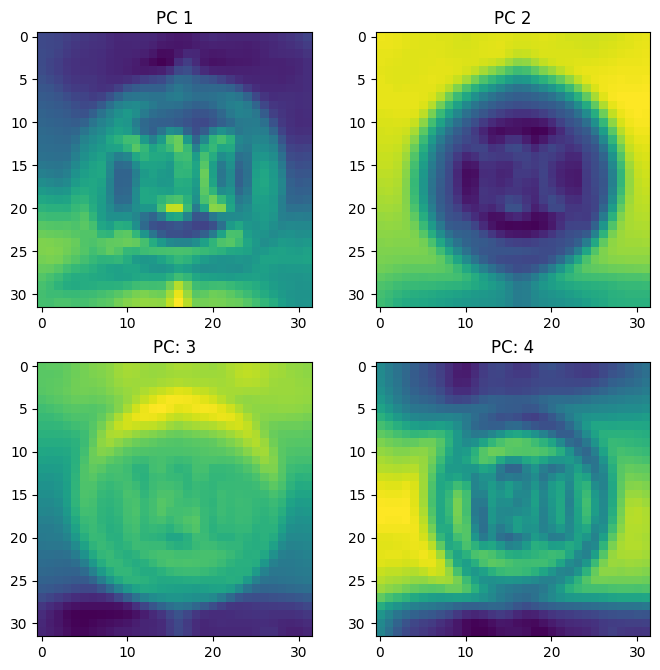

Test accuracy: 0.9804
Test loss norm: 0.3800
**********
Current Fold: 1
Test accuracy: 0.9882
Test loss norm: 0.4071
**********
Current Fold: 2
Test accuracy: 0.9569
Test loss norm: 0.4135
**********
Current Fold: 3
Test accuracy: 0.9686
Test loss norm: 0.3946
**********
Current Fold: 4
Test accuracy: 0.9608
Test loss norm: 0.4063
**********
Current Fold: 5
Test accuracy: 0.9647
Test loss norm: 0.4167
**********
Current Fold: 6
Test accuracy: 0.9686
Test loss norm: 0.4038
**********
Current Fold: 7
Test accuracy: 0.9725
Test loss norm: 0.3967
1
**********
Current Fold: 8
Test accuracy: 0.9333
Test loss norm: 0.4311
2
**********
Current Fold: 9
Test accuracy: 0.9608
Test loss norm: 0.3978
Average test accuracy over 10 folds: 0.9654901960784315
std of test accuracy over 10 folds: 0.014008291058424898
Average test loss per example and class over 10 folds: 0.4047642166642362


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y

load_data_binary = select_binarydata(load_data,7,8)
#data normalize

Debug = False
#recording data for plot

train_loss_record_all = []
# learning rate
lrs = [0.01, 0.0001,0.003]
for lr in range(np.size(lrs)) : 
    Alpha = lrs[lr]
    train_loss_record = []
    holdout_loss_record = []
    holdout_accuracy_record = []
    test_accuracy_record = []
    train_accuracy_record = []
    n_components = 200
    epochs_print = [50, 100, 150, 200, 250, 300,1000]
    epochs = 1000
    k = 10
    cur_fold = 0
    total_test_accuracy = 0.0
    total_test_loss = 0.0

    #fold sets add
    first_plot = True
    for train, valid, test in generate_k_fold_set((load_data_binary),k=10):
        print("**********")
        print(f"Current Fold: {cur_fold}")
        test_accuracy = []
        holdout_accuracy = []

        w = np.zeros((n_components+1))
        b = 0
        #first_plot = True
        train_data, train_label = train
        valid_data, valid_label = valid
        test_data, test_label = test


        pca = PCA(n_components)
        projected = pca.fit_transform(train_data)
        #plot first principle component
        if first_plot == True : 
            pca.plot_PC()
            first_plot = False
        train_d = projected     
        valid_d = pca.transform(valid_data)
        test_d = pca.transform(test_data)
        train_l = np.copy(train_label)//8
        valid_l = np.copy(valid_label)//8
        test_l = np.copy(test_label)//8

        logistic = LogisticRegression(Alpha,n_components)

        for epoch in range(epochs):
            #logistic model 
            train_y = logistic.logistic_model(w, train_d,b)
            #loss check
            train_loss = logistic.loss_binary(train_y, train_l)
            train_loss_norm = train_loss/len(train_y)
            #gradient check
            train_loss_record.append(train_loss_norm)
            train_accuracy = logistic.check_accuracy(train_y, train_l)
            train_accuracy_record.append(train_accuracy)
            #process for validation sets only checking the accuray, not updating the weight
            holdout_y = logistic.logistic_model(w,valid_d,b)
            holdout_loss = logistic.loss_binary(holdout_y, valid_l)
            holdout_loss_norm = holdout_loss/len(holdout_y)
            holdout_accuracy = logistic.check_accuracy(holdout_y, valid_l)
            holdout_loss_record.append(holdout_loss_norm)
            holdout_accuracy_record.append(holdout_accuracy)
            #evaluate best option for test sets
            if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * epochs:]):
                best_w = w
                best_b = b

            #update the weight
            w,b = logistic.update_weight(w,b,train_d, train_y, train_l)

            if Debug : 
                if (epoch + 1) in epochs_print:
                    print(f' epoch: {epoch + 1}, train accuracy and loss: {train_accuracy, train_loss_norm}')

        test_y = logistic.logistic_model(best_w, test_d, best_b)
        test_accuracy = logistic.check_accuracy(test_y, test_l)            
        test_accuracy_record.append(test_accuracy)

        print(f'Test accuracy: {test_accuracy:.4f}')
        total_test_accuracy += test_accuracy
        test_loss = logistic.loss_binary(test_y, test_l)
        test_loss_norm = test_loss / len(test_y)
        total_test_loss += test_loss_norm
        print(f"Test loss norm: {test_loss_norm:.4f}")    


        #update fold
        cur_fold += 1


    print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
    print(f'std of test accuracy over {k} folds: {np.std(test_accuracy_record)}')
    print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')
    train_loss_record_all.append(train_loss_record)
    
    

    

In [16]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] = new_data[j] + data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

def get_data_at_epoch_fold(data, epoch, total_num_folds=10):
    # Returns a new list of data points at a specified epoch from all folds
    # data = [fold1....fold10]
    # epoch is 0-indexed
    epoch_per_fold = len(data) // total_num_folds
    new_data = [data[f * (epoch_per_fold) + epoch] for f in range(total_num_folds)]
    return new_data # [epoch n from fold1, epoch n from fold2, ..., epoch n from fold10]


Text(0.5, 1.0, 'Loss normalized per example and class vs. Epochs')

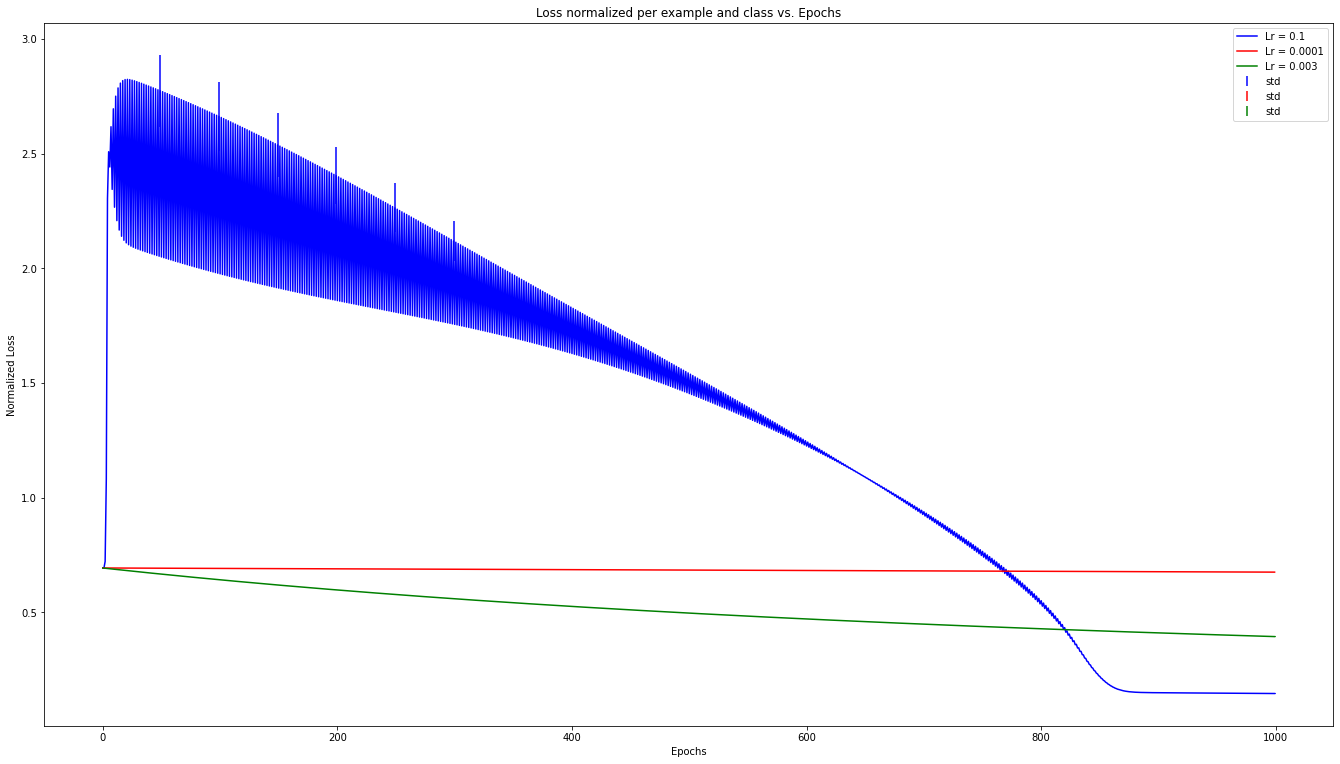

In [19]:

fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

epochs_error_bar = epochs_print # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss1 = average_out_data_k(train_loss_record_all[0])
average_train_loss2 = average_out_data_k(train_loss_record_all[1])
average_train_loss3 = average_out_data_k(train_loss_record_all[2])

train_loss_error_bar_y1 = [average_train_loss1[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr1 = [np.std(get_data_at_epoch_fold(train_loss_record_all[0], epoch)) for epoch in epochs_error_bar_0]

train_loss_error_bar_y2 = [average_train_loss2[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr2 = [np.std(get_data_at_epoch_fold(train_loss_record_all[1], epoch)) for epoch in epochs_error_bar_0]

train_loss_error_bar_y3 = [average_train_loss3[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr3 = [np.std(get_data_at_epoch_fold(train_loss_record_all[2], epoch)) for epoch in epochs_error_bar_0]



axs.plot(average_train_loss1, '-b', label='Lr = 0.1')
axs.errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y1, yerr=train_loss_error_bar_yerr1, label='std', fmt='-b',linestyle='')
axs.plot(average_train_loss2, '-r', label='Lr = 0.0001')
axs.errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y2, yerr=train_loss_error_bar_yerr2, label='std', fmt='-r',linestyle='')
axs.plot(average_train_loss3, '-g', label='Lr = 0.003')
axs.errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y3, yerr=train_loss_error_bar_yerr3, label='std', fmt='-g',linestyle='')

axs.legend()
axs.set_xlabel('Epochs')
axs.set_ylabel('Normalized Loss')
axs.set_title('Loss normalized per example and class vs. Epochs')




In [ ]:
##Q5 - (d) - Evaluate the model on Curve Left(19) vs Right(20) using the aligned dataset

(34799, 1024) (34799,)
**********
Current Fold: 0


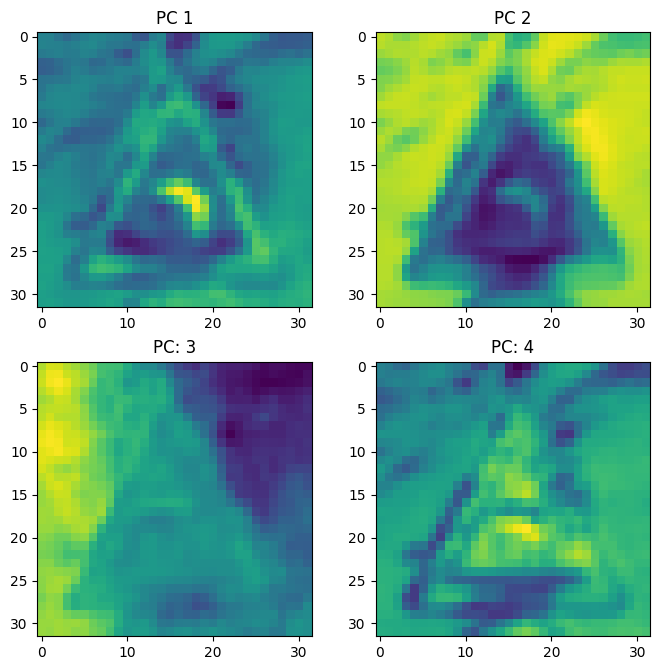

Test accuracy: 0.6667
Test loss norm: 0.5674
**********
Current Fold: 1
Test accuracy: 0.7500
Test loss norm: 0.5303
**********
Current Fold: 2
Test accuracy: 0.7708
Test loss norm: 0.5106
**********
Current Fold: 3
Test accuracy: 0.7083
Test loss norm: 0.5363
**********
Current Fold: 4
Test accuracy: 0.6667
Test loss norm: 0.5440
**********
Current Fold: 5
Test accuracy: 0.6875
Test loss norm: 0.5213
**********
Current Fold: 6
Test accuracy: 0.8125
Test loss norm: 0.4971
**********
Current Fold: 7
Test accuracy: 0.9167
Test loss norm: 0.4816
1
**********
Current Fold: 8
Test accuracy: 0.8333
Test loss norm: 0.4910
2
**********
Current Fold: 9
Test accuracy: 0.6667
Test loss norm: 0.5763
Average test accuracy over 10 folds: 0.7479166666666667
std of test accuracy over 10 folds: 0.08092885249814598
Average test loss per example and class over 10 folds: 0.525590193357589


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y

load_data_binary = select_binarydata(load_data,19,20)
#data normalize

Debug = False
#recording data for plot
train_loss_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

train_accuracy_record = []

Alpha  = 0.003
n_components = 200
epochs_print = [50, 100, 150, 200, 250, 300]
epochs = 300
cur_fold = 0
k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

#fold sets add
first_plot = True
for train, valid, test in generate_k_fold_set((load_data_binary),k=10):
    print("**********")
    print(f"Current Fold: {cur_fold}")
    test_accuracy = []
    holdout_accuracy = []

    #w = np.random.rand(n_components)
    w = np.zeros((n_components+1))
    b = 0
    #first_plot = True
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    

    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    #plot first principle component
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.transform(valid_data)
    test_d = pca.transform(test_data)
    train_l = np.copy(train_label)//20
    valid_l = np.copy(valid_label)//20
    test_l = np.copy(test_label)//20
    
    logistic = LogisticRegression(Alpha,n_components)
  
    for epoch in range(epochs):
        #logistic model 
        train_y = logistic.logistic_model(w, train_d,b)
        #loss check
        train_loss = logistic.loss_binary(train_y, train_l)
        train_loss_norm = train_loss/len(train_y)
        #gradient check
        train_loss_record.append(train_loss_norm)
        train_accuracy = logistic.check_accuracy(train_y, train_l)
        train_accuracy_record.append(train_accuracy)
        #process for validation sets only checking the accuray, not updating the weight
        holdout_y = logistic.logistic_model(w,valid_d,b)
        holdout_loss = logistic.loss_binary(holdout_y, valid_l)
        holdout_loss_norm = holdout_loss/len(holdout_y)
        holdout_accuracy = logistic.check_accuracy(holdout_y, valid_l)
        holdout_loss_record.append(holdout_loss_norm)
        holdout_accuracy_record.append(holdout_accuracy)
        #evaluate best option for test sets
        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * epochs:]):
            best_w = w
            best_b = b
            
        #update the weight
        w,b = logistic.update_weight(w,b,train_d, train_y, train_l)
    
        if Debug : 
            if (epoch + 1) in epochs_print:
                print(f' epoch: {epoch + 1}, train accuracy and loss: {train_accuracy, train_loss_norm}')

    test_y = logistic.logistic_model(best_w, test_d, best_b)
    test_accuracy = logistic.check_accuracy(test_y, test_l)            
    test_accuracy_record.append(test_accuracy)
    
    print(f'Test accuracy: {test_accuracy:.4f}')
    total_test_accuracy += test_accuracy
    test_loss = logistic.loss_binary(test_y, test_l)
    test_loss_norm = test_loss / len(test_y)
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")    


    #update fold
    cur_fold += 1


print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
print(f'std of test accuracy over {k} folds: {np.std(test_accuracy_record)}')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')

    










Text(0.5, 1.0, 'Accuracy vs. Epochs')

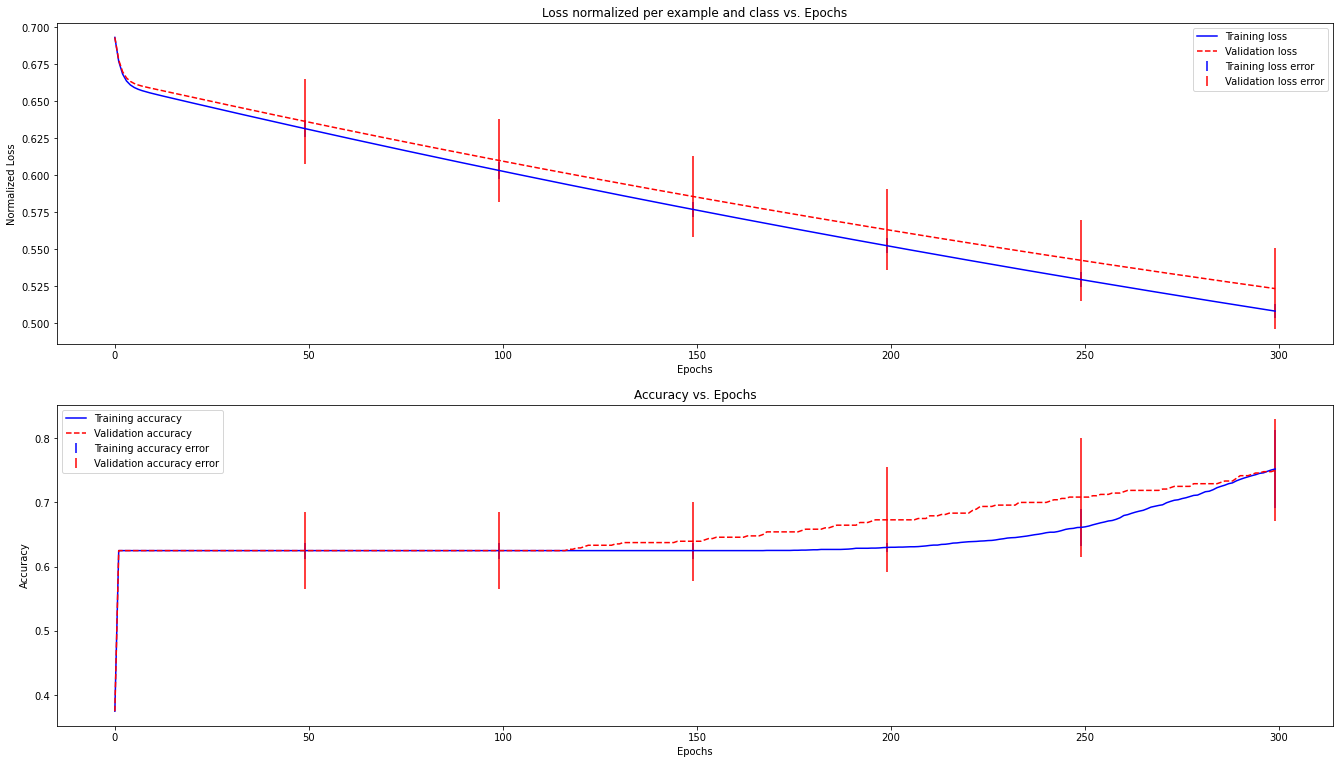

In [24]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)

train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]


axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b',linestyle='')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r',linestyle='')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b',linestyle='')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r',linestyle='')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')


# standard deviation error bars.


In [ ]:
##Extra Credit for balancing datasets

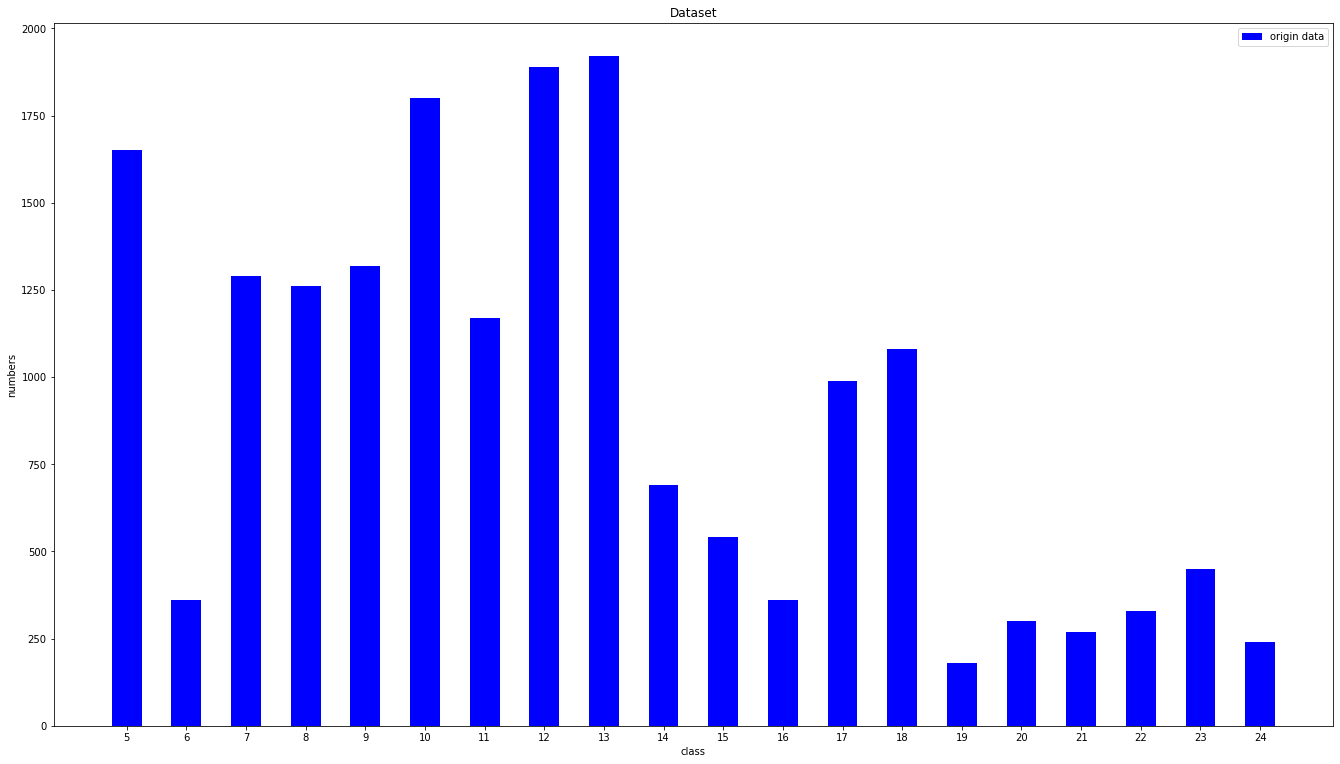

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
n_components = 100
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y
#data normalize

def balance_data(dataset):
    Data, labels = dataset
    #top 6 image sets drop -> lowest 6 image sets duplicate
    cnt_array = np.bincount(labels)
    
    # sort. higher data remove, find top 5 
    top5 = (cnt_array.argsort()[-6:][::-1])
    for i in range(np.size(top5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_high = np.where(labels == top5[i])
        k = np.array(idx_high)[0,1:np.size(idx_high)//5] 
        Data = np.delete(Data,  k)
        labels = np.delete(labels,  k)
      
    # sort. higher data remove, find top 5 
    low5 = (cnt_array.argsort()[1:7][::-1])
    

    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//1]
        Data = np.concatenate([Data[:],  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])
         
    cnt_array_balance = np.bincount(labels)
   
    return   cnt_array, cnt_array_balance

origin, new = balance_data(load_data)

fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(18.5, 10.5)
k = np.arange(5,25)
axs.bar(k,origin[k],color = 'b',label = 'origin data',width = 0.5)
#axs.bar(k,new[k],color = 'r',label = 'balanced data',width = 0.5)
axs.legend();
axs.set_xticks(k)
axs.set_xlabel('class')
axs.set_ylabel('numbers')
axs.set_title('Dataset')

plt.show()



In [74]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set, onehot_encode,onehot_decode,z_score_normalize,select_binarydata
from model.logistic import LogisticRegression

#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
n_components = 100
X,Y = traffic_sign(True) # check true and false
#data normalize
train_data_normalized = X.astype(np.float32) # cast to float32 as float64 running out of memory
train_data_normalized = z_score_normalize(train_data_normalized) 
load_data = train_data_normalized, Y
#data normalize

def balance_data(dataset):
    Data, labels = dataset
    #top 6 image sets drop -> lowest 6 image sets duplicate
    D = np.copy(Data)
    L = np.copy(labels)
    selectTop = 10
    selectLow = 20

    cnt_array = np.bincount(labels)
    
    # sort. higher data remove, find top 5 
    top5 = (cnt_array.argsort()[-selectTop:][::-1])
    for i in range(np.size(top5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_high = np.where(labels == top5[i])
        k = np.array(idx_high)[0,1:np.size(idx_high)//5] 
        Data = np.delete(Data,  k,0)
        labels = np.delete(labels,  k,0)
      
    # sort. higher data remove, find top 5 
    
    low5 = (cnt_array.argsort()[1:selectLow+1][::-1])


    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//1]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
    
    cnt_array_balance = np.bincount(labels)
   
    return   Data, labels


def balance_data_plot(dataset):
    Data, labels = dataset
    #top 6 image sets drop -> lowest 6 image sets duplicate
    #permutation    
    
    D = np.copy(Data)
    L = np.copy(labels)
    selectTop = 10
    selectLow = 24
    selectLows = 5

    cnt_array = np.bincount(labels)
    
    # sort. higher data remove, find top 5 
    top5 = (cnt_array.argsort()[-selectTop:][::-1])
    for i in range(np.size(top5)):
        # 5 higher data remove ?% 5 lowest data duplicate ?%
        idx_high = np.where(labels == top5[i])
        # random pick with in range
        randsize = np.size(idx_high)//4
        rand = random.sample(range(randsize), randsize)
        
        
        k = np.array(idx_high)[0,rand] 
        Data = np.delete(Data,  k,0)
        labels = np.delete(labels,  k,0)
      
    # sort. higher data remove, find top 5 
    
    low5 = (cnt_array.argsort()[1:selectLow+1][::-1])

    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//1]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
        
    low5 = (cnt_array.argsort()[1:selectLows+1][::-1])

    for i in range(np.size(low5)):
        # 5 higher data remove 5%, 5 lowest data duplicate
        idx_low = np.where(labels == low5[i])
        k = np.array(idx_low)[0,1:np.size(idx_low)//2]
        Data = np.concatenate([Data,  Data[k]])
        labels = np.concatenate([labels[:], labels[k]])    
            
    
    cnt_array_balance = np.bincount(labels)
   
    return   cnt_array, cnt_array_balance



In [64]:
print(random.sample(range(10), 10))


[1, 8, 3, 4, 0, 5, 9, 7, 2, 6]


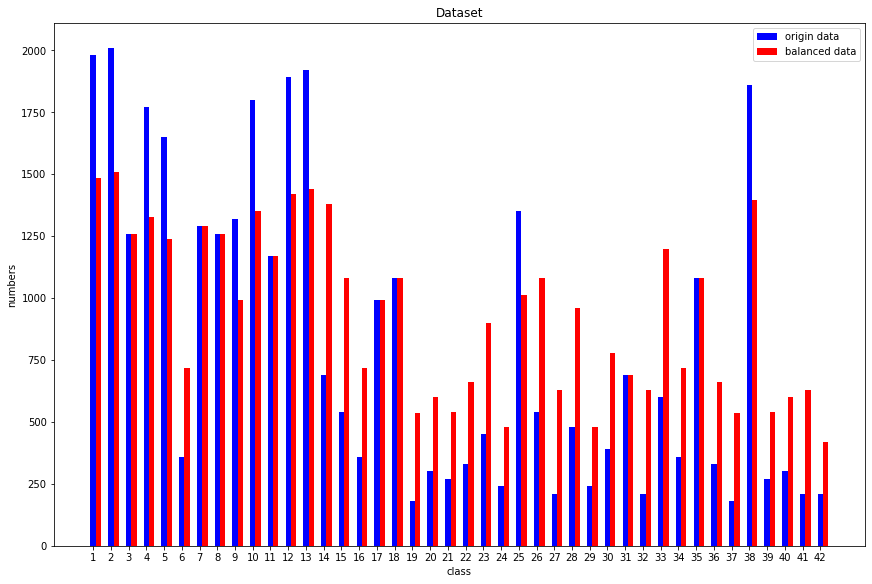

In [75]:

origin, new = balance_data_plot(load_data)

fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(12, 8)
k = np.arange(1,43)

axs.bar(k,origin[k],color = 'b',label = 'origin data',width = 0.3)
axs.bar(k+0.3,new[k],color = 'r',label = 'balanced data',width = 0.3)
axs.legend();
axs.set_xticks(k)
axs.set_xlabel('class')
axs.set_ylabel('numbers')
axs.set_title('Dataset')

plt.show()



In [ ]:
## extra credit

Current Fold: 0


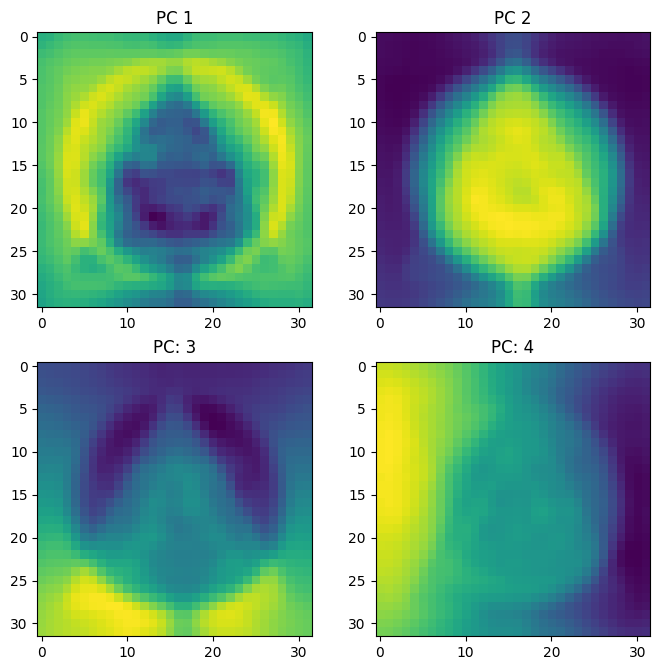

(29729, 300)
(3715, 300)
(3715, 300)
 epoch: 50, train accuracy: 0.8611, train_loss_norm:0.0292, valid_acc: 0.8406, valid_loss_norm: 0.0427
 epoch: 100, train accuracy: 0.8791, train_loss_norm:0.0213, valid_acc: 0.8592, valid_loss_norm: 0.0377
 epoch: 150, train accuracy: 0.8920, train_loss_norm:0.0178, valid_acc: 0.8681, valid_loss_norm: 0.0353
 epoch: 200, train accuracy: 0.9005, train_loss_norm:0.0158, valid_acc: 0.8767, valid_loss_norm: 0.0330
 epoch: 250, train accuracy: 0.9066, train_loss_norm:0.0143, valid_acc: 0.8789, valid_loss_norm: 0.0324
 epoch: 300, train accuracy: 0.9120, train_loss_norm:0.0133, valid_acc: 0.8832, valid_loss_norm: 0.0313
Test accuracy: 0.8808
Test loss norm: 0.0319
Current Fold: 1
(29729, 300)
(3715, 300)
(3715, 300)
 epoch: 50, train accuracy: 0.8599, train_loss_norm:0.0294, valid_acc: 0.8428, valid_loss_norm: 0.0421
 epoch: 100, train accuracy: 0.8782, train_loss_norm:0.0215, valid_acc: 0.8592, valid_loss_norm: 0.0377
 epoch: 150, train accuracy: 0.8900

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize, append_bias
from model.softmax import SoftmaxRegression

### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

load_data = X, y

X, y = balance_data(load_data)

## (i) With PCA on aligned

DEBUG = False

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        holdout_y = softmax_model.model(valid_d)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '\
                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')
            if DEBUG:
                test_y = softmax_model.model_w(test_d, best_w)
                test_y_1 = softmax_model.model(test_d)

                test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)
                test_accuracy_1 = softmax_model.accuracy(test_y_1, test_label_onehot)

                raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
                test_loss_norm = raw_test_loss / len(test_d) / num_classes

                print(f'MODEL_W: Test accuracy: {test_accuracy:.4f}', f'Test loss norm: {test_loss_norm:.4f}')
                print(f'MODEL: Test accuracy: {test_accuracy_1:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    test_accuracy_record.append(test_accuracy)

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {np.mean(test_accuracy_record):.4f} (+/- {np.std(test_accuracy_record):.4f})')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k:.4f}')


Text(0.5, 1.0, 'Accuracy vs. Epochs')

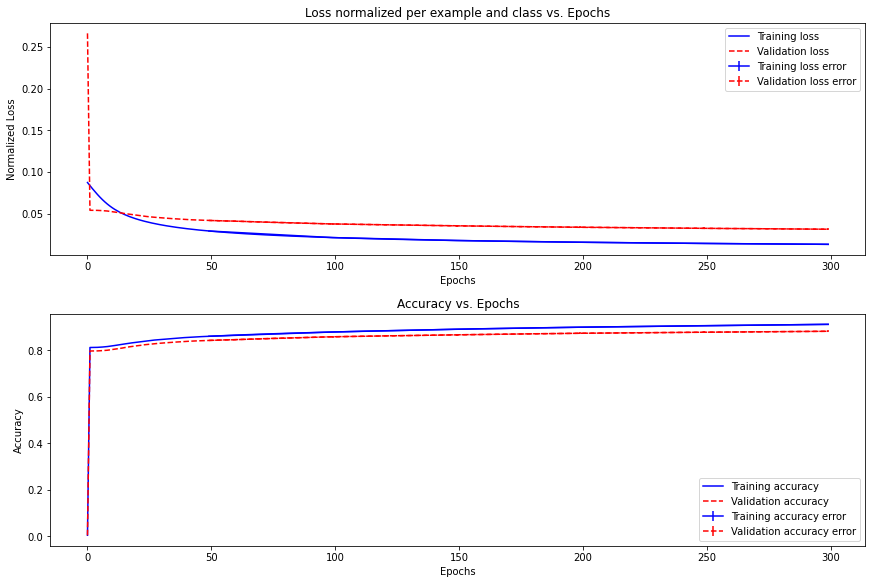

In [78]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] += data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

def get_data_at_epoch_fold(data, epoch, total_num_folds=10):
    # Returns a new list of data points at a specified epoch from all folds
    # data = [fold1....fold10]
    # epoch is 0-indexed
    epoch_per_fold = len(data) // total_num_folds
    new_data = [data[f * (epoch_per_fold) + epoch] for f in range(total_num_folds)]
    return new_data # [epoch n from fold1, epoch n from fold2, ..., epoch n from fold10]

fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(12, 8)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)
train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

# For Q6b_ii comparison
batch_average_train_loss = average_train_loss 
batch_average_train_loss_error_bar_y = train_loss_error_bar_y
batch_average_train_loss_error_bar_yerr = train_loss_error_bar_yerr

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]

axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')
